# <center>ASSIGNMENT 4 </center>

<b>a) Come up with a noise model for Livingston and Hanford separately.
Describe in comments how you go about doing this. Please mention some- thing about how you smooth the power spectrum and how you deal with lines (if at all). Please also explain how you window the data.</b>

First, we need to read the h5py files.

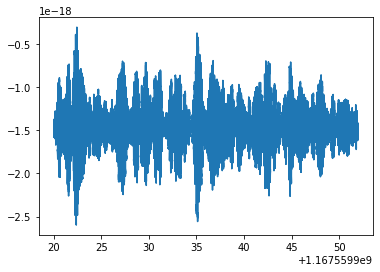

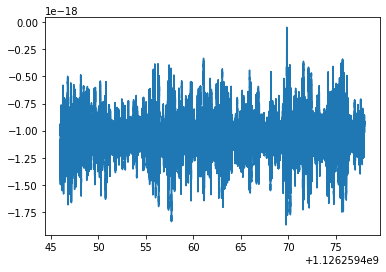

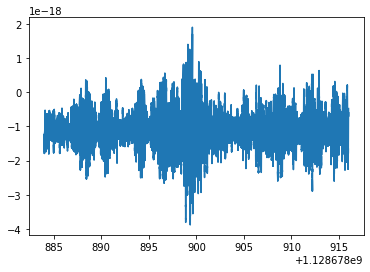

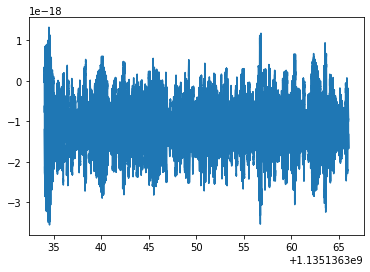

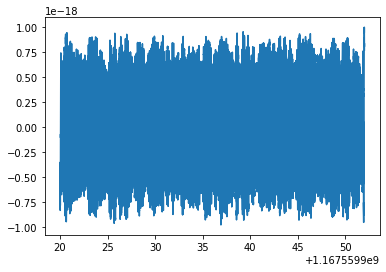

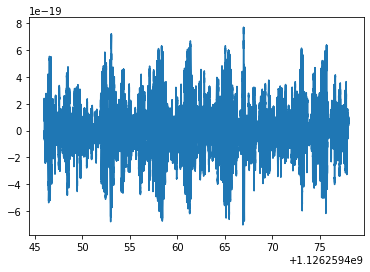

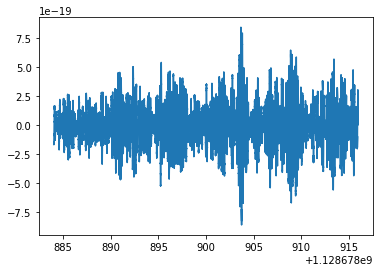

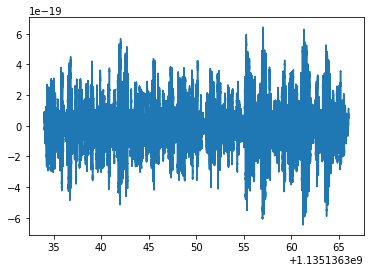

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import h5py

plt.ion()


def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    time=np.linspace(gpsStart,gpsStart+duration,len(strain))
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,time

def readloop(files):
    L=len(files)
    strain_L=np.zeros((L,131072))
    dt_L=np.zeros(L)
    time_L=np.zeros((L,131072))
    for i in range(L):
        strain_L[i],dt_L[i],time_L[i]=read_file(files[i])
        plt.figure()
        plt.plot(time_L[i],strain_L[i])
    return strain_L,dt_L,time_L
    

files_L='/Users/jmlascar/LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5'
files_H='/Users/jmlascar/LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5','/Users/jmlascar/LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5'
template='/Users/jmlascar/LOSC_Event_tutorial/GW170104_4_template.hdf5','/Users/jmlascar/LOSC_Event_tutorial/GW150914_4_template.hdf5','/Users/jmlascar/LOSC_Event_tutorial/LVT151012_4_template.hdf5','/Users/jmlascar/LOSC_Event_tutorial/GW151226_4_template.hdf5'

strain_L,dt_L,time_L=readloop(files_L)
strain_H,dt_H,time_H=readloop(files_H)




To avoid any "ringing" (that is, noisy features from discontinuities), we window the data. Here we've used the np.blackman window.

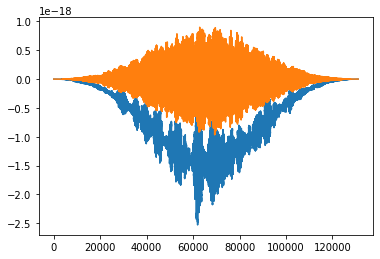

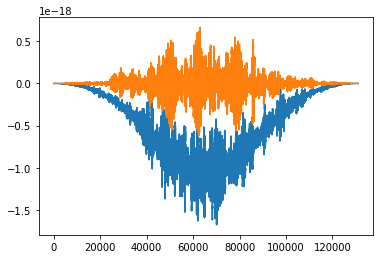

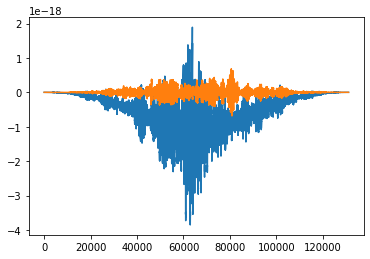

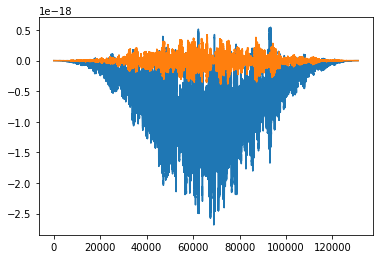

In [5]:
#1. window 
window_strain_L=[]
window_strain_H=[]

for i in range(len(files_L)):
    window_L=np.blackman(len(strain_L[i]))
    new_strain_L=strain_L[i]*window_L
    window_strain_L.append(new_strain_L)
    window_H=np.blackman(len(strain_H[i]))
    new_strain_H=strain_H[i]*window_H
    window_strain_H.append(new_strain_H)
    plt.figure()
    plt.plot(new_strain_L)
    plt.plot(new_strain_H)

    

To estimate our "strain-equivalent" noise model, we first calculate the power spectral densities (PSDs), which are the averages of the square of the fast fourier transforms of our data. 

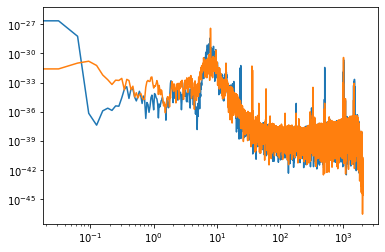

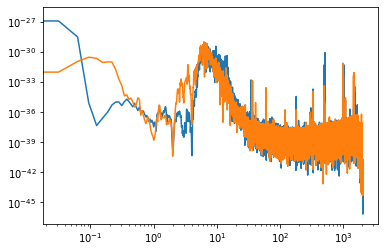

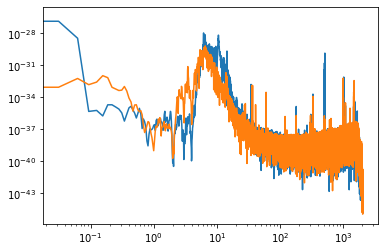

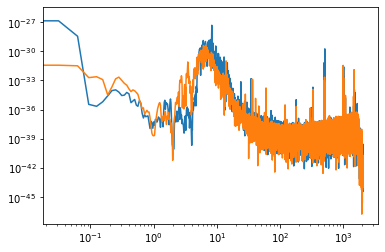

In [6]:
PSD_L=[]
PSD_H=[]
frequenciesL=[]
frequenciesH=[]
for i in range(len(files_L)):
    FFT_L=np.fft.rfft(window_strain_L[i])
    New_PSD_L=np.abs(FFT_L)**2
    PSD_L.append(New_PSD_L)
    freq_L=np.fft.rfftfreq(time_L[i].shape[-1],d=dt_L[i])
    frequenciesL.append(freq_L)
    
    FFT_H=np.fft.rfft(window_strain_H[i])
    New_PSD_H=np.abs(FFT_H)**2
    PSD_H.append(New_PSD_H)
    freq_H=np.fft.rfftfreq(time_H[i].shape[-1],d=dt_H[i])
    frequenciesH.append(freq_H)
    plt.figure()
    plt.loglog(freq_L,New_PSD_L)
    plt.loglog(freq_H,New_PSD_H)

We want to smooth this power spectrum by sliding a gaussian accross it, and to cut the low and high frequencies.
Then, 
b) Use that noise model to search the four sets of events using a matched filter.

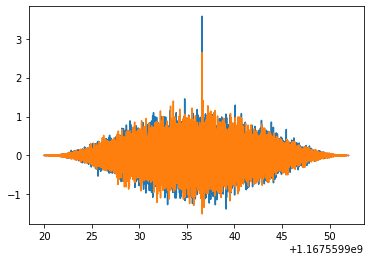

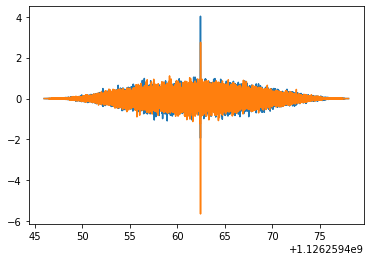

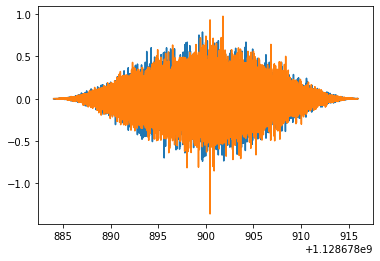

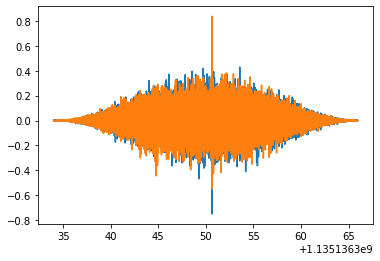

In [66]:


def smooth_data(vec,fwhm):
    n=len(vec)
    x=np.arange(n)
    x[int(n/2):]=x[int(n/2):]-n
    sig=fwhm/np.sqrt(8*np.log(2))
    y=np.exp(-0.5*x**2/sig**2)
    y=y/np.sum(y)
    
    vecft=np.fft.rfft(vec)
    yft=np.fft.rfft(y)
    vec_smooth=np.fft.irfft(yft*vecft,n)
    return vec_smooth


mf_L=[]
mf_H=[]

for i in range(len(files_L)):
    #Whitening to get the noise model
    vec_L=smooth_data(PSD_L[i],20)
    Vmhalf=1/np.sqrt(vec_L)
    Vmhalf[:200]=0 #Getting rid of low and high frequencies
    Vmhalf[53000:]=0
    x=np.linspace(-1,1,131072)
    strainft_L=np.fft.rfft((0.5*np.cos(np.pi*x)+0.5)*strain_L[i])
    strainft_white_L=Vmhalf*strainft_L 
    strain_white_L=np.fft.irfft(strainft_white_L,len(strain_L[i]))


    tl,th=read_template(template[i])
    window_tl=np.blackman(len(tl)) #we also window the template, though we don't smooth it
    windowtl=tl*window_tl
    tl_ft=np.fft.rfft(windowtl*(0.5*np.cos(np.pi*x)+0.5))
    tlft_white=tl_ft*Vmhalf
    tl_white=np.fft.irfft(tlft_white,len(windowtl))
    
    
    mf_ft_L=strainft_white_L*np.conj(tlft_white) #Matched filter
    mf=np.fft.irfft(mf_ft_L,131072)
    mf=np.fft.fftshift(mf)
    mf_L.append(mf)
    
    
    vec_H=smooth_data(PSD_H[i],20)
    VmhalfH=1/np.sqrt(vec_H)
    VmhalfH[:200]=0
    VmhalfH[53000:]=0
    x=np.linspace(-1,1,131072)
    strainft_H=np.fft.rfft((0.5*np.cos(np.pi*x)+0.5)*strain_H[i])
    strainft_white_H=Vmhalf*strainft_H
    strain_white_H=np.fft.irfft(strainft_white_H,len(strain_H[i]))

    window_th=np.blackman(len(th))
    windowth=th*window_th
    th_ft=np.fft.rfft(windowth*(0.5*np.cos(np.pi*x)+0.5))
    thft_white=th_ft*VmhalfH
    th_white=np.fft.irfft(thft_white,len(windowth))

    mf_ft_H=strainft_white_H*np.conj(thft_white)
    mfH=np.fft.irfft(mf_ft_H,131072)
    mfH=np.fft.fftshift(mfH)
    mf_H.append(mfH)
    
    

plt.figure()

plt.plot(time_L[0],mf_L[0])
plt.plot(time_H[0],mf_H[0])
#plt.xlim(right=1167559935)


plt.figure()
plt.plot(time_L[1],mf_L[1])
plt.plot(time_H[1],mf_H[1])
#plt.xlim(right=1126259462)

plt.figure()
plt.plot(time_L[2],mf_L[2])
plt.plot(time_H[2],mf_H[2])
#plt.xlim(right=1128678900)

plt.figure()
plt.plot(time_L[3],mf_L[3])
plt.plot(time_H[3],mf_H[3])
#plt.xlim(right=1135136350)

    

c) Estimate a noise for each event, and from the output of the matched filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Livingston + Hanford events.

In [62]:
from IPython.display import Latex
Latex(r"""\begin{eqnarray}

m=(A^T(N^-1/2N^{-1/2})d)(A^T(N^{-1/2}N^{-1/2})A)^{-1}\\
N^T, (AB)^T=B^TA^T\\
m=(N^{-1/2} A)^T I (N^{1/2} d))((N^1/2 A)^T I (N^-1/2 A))^{-1}\\
<m m^T>=<(A^TN^{-1}A)^{-1}A^TN^{-1}Ad d^T N^{-1}A(A^TN^{-1}A){-1}> \\
dd^T \approx N \\
<m m^T>=<(A^T N^{-1} A)^-1>=<(N^{-1/2}A)^T I (N^{-1/2}A)^-1>\\
 
SNR=m/\sigma_m = (N^{-1/2} A)^T I (N^{1/2} d))((N^{1/2} A)^T I (N^{-1/2} A))^{-1}
\end{eqnarray}
""")

<IPython.core.display.Latex object>

d) Compare the signal-to-noise you get from the scatter in the matched filter to the analytic signal-to-noise you expect from your noise model. How close are they? If they disagree, can you explain why?

e) From the template and noise model, find the frequency from each event where half the weight comes from above that frequency and half below.

f) How well can you localize the time of arrival (the horizontal shift of your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times as different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?